
Цей код створює прототип (Proof-of-Concept, PoC) для персонального додатка для ведення нотаток, що використовує великі мовні моделі (LLMs) для зберігання та пошуку нотаток. Додаток дозволяє зберігати текстові нотатки, швидко отримувати доступ до останніх нотаток та шукати релевантні нотатки за допомогою запитів природною мовою.

#### Опис функцій
1. **Імпорт бібліотек та налаштування моделей і баз даних**
    - Імпортуються необхідні бібліотеки, такі як `torch`, `Pinecone`, `transformers`, `nltk`, та `uuid`.
    - Ініціалізується Pinecone для роботи з векторними базами даних.
    - Завантажуються токенізатор та модель для перетворення тексту у вектори.

2. **Ініціалізація Pinecone**
    - Виконується підключення до Pinecone за допомогою API-ключа.
    - Створюється або підключається існуючий індекс для зберігання векторів нотаток.

3. **Функція `embed_text`**
    - Перетворює текст на вектори за допомогою завантаженої моделі.

4. **Функція `validate_vector`**
    - Перевіряє, чи є вектор дійсним (правильний формат і розмір).

5. **Функція `add_note`**
    - Додає нотатку у векторний індекс Pinecone.
    - Перевіряє, чи вектор є дійсним, та додає його в індекс разом з унікальним ідентифікатором та текстом нотатки.

6. **Функція `search_notes`**
    - Шукає релевантні нотатки.
    - Використовує вектори для пошуку найближчих нотаток у Pinecone.

7. **Ініціалізація моделі для генерації тексту**
    - Завантажується модель Meta-Llama для генерації тексту на основі запитів користувача.

8. **Функція `generate_response`**
    - Генерує відповіді на запити користувача на основі контексту знайдених нотаток.

9. **Головна функція `main`**
    - Реалізує інтерфейс командного рядка для взаємодії з користувачем.
    - Дозволяє додавати нові нотатки, шукати нотатки та виходити з програми.

#### Що можна покращити
1. **Розширення функціоналу пошуку**
    - Додати підтримку більш складних запитів, таких як пошук за датою або категорією.

2. **Покращення інтерфейсу**
    - Додати можливість видалення або редагування існуючих нотаток.

3. **Оптимізація**
    - Можливість використання іншої LLM моделі, яка буде працювати через API, таким чином ми значно знизимо навантаження на девайс користувача.


#### Висновок
Цей код забезпечує базовий функціонал для ведення нотаток та їх опрацювання за допомогою LLM та векторних баз даних. Прототип може бути розширений та оптимізований для покращення продуктивності та зручності використання, а також для додавання нових функцій, що відповідають вимогам користувачів.


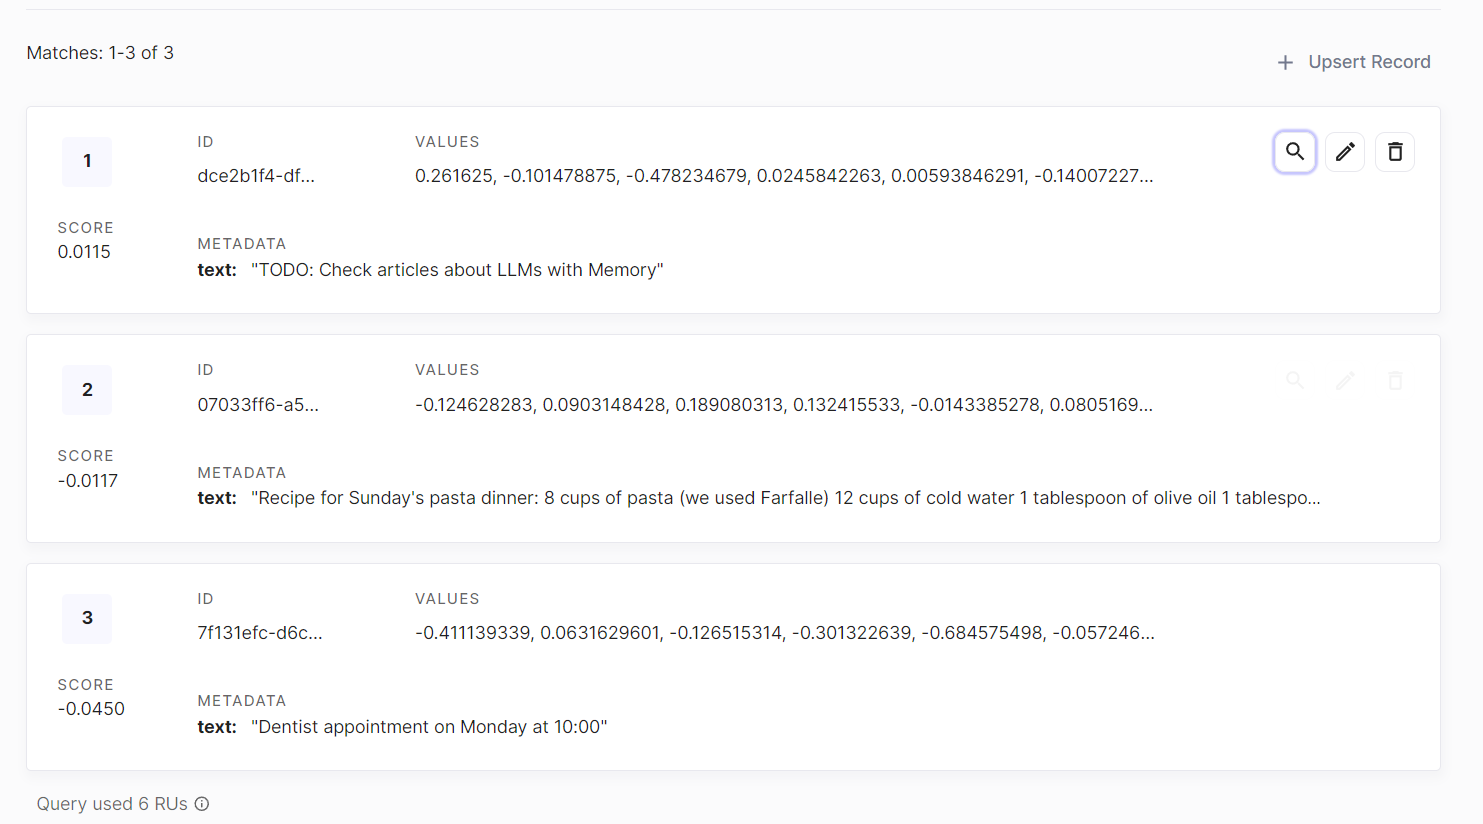

In [1]:
from google.colab import output
output.enable_custom_widget_manager()
!pip install huggingface_hub
from huggingface_hub import login
login()

In [4]:
# Импорт библиотек и настройка моделей и баз данных
import os
import torch
from pinecone import Pinecone, ServerlessSpec
from transformers import AutoTokenizer, AutoModel, pipeline
from nltk.tokenize import sent_tokenize
import nltk
import uuid

# Инициализация Pinecone
api_key = "api_key"
pinecone = Pinecone(api_key=api_key)

# Создание или подключение к существующему индексу Pinecone
index_name = "notes1"
if index_name not in pinecone.list_indexes():
    pinecone.create_index(
        name=index_name,
        dimension=384,
        spec=ServerlessSpec(cloud='aws', region='us-east-1')
    )
index = pinecone.Index(index_name)

nltk.download('punkt')

# Инициализация токенизатора и модели для кодирования текста в векторы
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

def embed_text(text):
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        embeddings = model(**tokens)
    return embeddings.last_hidden_state.mean(dim=1).squeeze().tolist()

def validate_vector(vector):
    return isinstance(vector, list) and all(isinstance(i, float) for i in vector) and len(vector) == 384

def add_note(note):
    try:
        vector = embed_text(note)
        if validate_vector(vector):
            unique_id = str(uuid.uuid4())
            index.upsert(vectors=[(unique_id, vector, {"text": note})])
            print(f"Заметка добавлена: {note}")
        else:
            print("Заметка не добавлена из-за недействительного вектора.")
    except Exception as e:
        print(f"Ошибка при добавлении заметки: {e}")

def search_notes(query):
    try:
        query_vector = embed_text(query)
        results = index.query(vector=query_vector, top_k=1, include_metadata=True)
        if results['matches']:
            closest_note = results['matches'][0]['metadata']['text']
            return closest_note
        else:
            return "No matching notes found."
    except Exception as e:
        return f"Ошибка при поиске: {e}"

def get_recent_notes(n):
    try:
        results = index.query(vector=[0.0] * 384, top_k=n, include_metadata=True)
        recent_notes = [match['metadata']['text'] for match in results['matches']]
        return recent_notes
    except Exception as e:
        return f"Ошибка при получении последних заметок: {e}"

# Инициализация модели для генерации текста
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
text_generator = pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16}
)

def generate_response(query, context):
    try:
        messages = [
            {"role": "system", "content": "You are a note-taking assistant. You will receive a query from the user searching through their notes, and you should respond to the query by providing the information found in the notes. For example, if there is a note saying Go to the store tomorrow at 11:00 AM, and the user asks, What are my plans for tomorrow? you should respond: Your plan for tomorrow is to go to the store at 11:00 AM."},
            {"role": "user", "content": query},
            {"role": "assistant", "content": f"В вашей записи есть заметка: {context}"}
        ]

        prompt = text_generator.tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )

        terminators = [
            text_generator.tokenizer.eos_token_id,
        ]

        outputs = text_generator(
            prompt,
            max_new_tokens=50,
            eos_token_id=terminators[0],
            do_sample=True,
            temperature=0.6,
            top_p=0.9,
        )

        response = outputs[0]["generated_text"][len(prompt):].strip()
        return response
    except Exception as e:
        return f"Ошибка при генерации ответа: {e}"

# Интерфейс командной строки
def main():
    while True:
        print("\nДоступные команды: add, search, exit")
        command = input("Введите команду: ")

        if command == "add":
            note = input("Введите заметку: ")
            add_note(note)

        elif command == "search":
            query = input("Введите запрос для поиска: ")
            context = search_notes(query)
            if "No matching notes found." not in context and "Ошибка" not in context:
                response = generate_response(query, context)
                print(f"Ответ на запрос: {response}")
            else:
                print(context)

        elif command == "recent":
            n = int(input("Введите количество последних заметок: "))
            recent_notes = get_recent_notes(n)
            print(f"Последние {n} заметок: {recent_notes}")

        elif command == "exit":
            print("Завершение работы...")
            break

        else:
            print("Неизвестная команда. Пожалуйста, попробуйте еще раз.")

if __name__ == "__main__":
    main()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.



Доступные команды: add, search, exit
Введите команду: add
Введите заметку: TODO: Check articles about LLMs with Memory
Заметка добавлена: TODO: Check articles about LLMs with Memory

Доступные команды: add, search, exit
Введите команду: add
Введите заметку: Dentist appointment on Monday at 10:00
Заметка добавлена: Dentist appointment on Monday at 10:00

Доступные команды: add, search, exit
Введите команду: Recipe for Sunday's pasta dinner: 8 cups of pasta (we used Farfalle) 12 cups of cold water 1 tablespoon of olive oil 1 tablespoon of sea salt or kosher salt 2 medium onions, diced 2 large garlic cloves, minced 1 tablespoon of Italian seasoning ...
Неизвестная команда. Пожалуйста, попробуйте еще раз.

Доступные команды: add, search, exit
Введите команду: search
Введите запрос для поиска: What plans do I have for this weekend?


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ответ на запрос: I apologize, it seems I made a mistake. I couldn't find any information about your plans for this weekend in your notes. Would you like me to search further or help you with something else?

Доступные команды: add, search, exit
Введите команду: What plans do I have for Monday?
Неизвестная команда. Пожалуйста, попробуйте еще раз.

Доступные команды: add, search, exit
Введите команду: search
Введите запрос для поиска: What plans do I have for Monday?


Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


Ответ на запрос: You have a dentist appointment on Monday at 10:00 AM.

Доступные команды: add, search, exit
Введите команду: exit
Завершение работы...
